<a href="https://colab.research.google.com/github/gsilver321/project_chd/blob/main/project2_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 CHD Paper
### DS 3001: Foundations of Machine Learning
### Gabe Silverstein, Rohan Chowla, Evan Stewart, and Rithwik Raman

## Summary

>  A one paragraph description of the question, methods, and results (about 350 words).




## Data Analysis



> One to two pages discussing the data and key variables, and any challenges in reading, cleaning, and preparing them for analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier

! git clone https://github.com/gsilver321/project_chd

Cloning into 'project_chd'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 18 (delta 3), reused 4 (delta 1), pack-reused 9
Receiving objects: 100% (18/18), 702.40 KiB | 8.36 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
df_train = pd.read_csv('project_chd/fhs_train_clean.csv') # data cleaning can be found at chd_cleaning.ipynb in GitHub
df_test = pd.read_csv('project_chd/fhs_test_clean.csv')

In [3]:
df_train.corr(method='kendall') # look for any relationships between variables. Use kendall coefficient to check for nonlinear relationship

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
sex,1.000000,-0.032634,-0.015515,0.198117,0.258593,-0.042453,0.007104,0.010722,0.020140,-0.051253,0.003470,0.061394,0.115394,-0.089771,-0.001255,0.097138
age,-0.032634,1.000000,-0.152685,-0.178461,-0.166228,0.092224,0.049907,0.246111,0.078816,0.199068,0.272477,0.145405,0.098332,-0.012041,0.074517,0.185685
education,-0.015515,-0.152685,1.000000,0.018438,0.010701,-0.016221,-0.028266,-0.085961,-0.038032,-0.025145,-0.107209,-0.055818,-0.120609,-0.045062,-0.025397,-0.060389
currentSmoker,0.198117,-0.178461,0.018438,1.000000,0.834697,-0.050967,-0.033461,-0.098607,-0.038440,-0.022107,-0.111075,-0.088206,-0.149895,0.060708,-0.068165,0.001644
cigsPerDay,0.258593,-0.166228,0.010701,0.834697,1.000000,-0.045587,-0.030472,-0.080183,-0.031612,-0.017653,-0.083113,-0.060188,-0.108014,0.062147,-0.070121,0.027312
BPMeds,-0.042453,0.092224,-0.016221,-0.050967,-0.045587,1.000000,0.124104,0.252398,0.053527,0.055855,0.162683,0.148483,0.064726,-0.015728,0.015824,0.086845
prevalentStroke,0.007104,0.049907,-0.028266,-0.033461,-0.030472,0.124104,1.000000,0.068668,-0.013348,-0.001264,0.046450,0.033646,-0.008960,-0.016434,0.003665,0.062357
prevalentHyp,0.010722,0.246111,-0.085961,-0.098607,-0.080183,0.252398,0.068668,1.000000,0.081750,0.133853,0.571121,0.510599,0.233331,0.115294,0.061179,0.163910
diabetes,0.020140,0.078816,-0.038032,-0.038440,-0.031612,0.053527,-0.013348,0.081750,1.000000,0.025129,0.072755,0.037296,0.059449,0.037928,0.171044,0.105644
totChol,-0.051253,0.199068,-0.025145,-0.022107,-0.017653,0.055855,-0.001264,0.133853,0.025129,1.000000,0.150631,0.117536,0.097305,0.051322,0.012545,0.077192


In [4]:
best = SelectKBest(score_func=chi2, k=5) # select 5 most important features using chi-squared independence test
fit = best.fit(df_train.drop(['TenYearCHD'], axis=1), df_train['TenYearCHD'])

scores = pd.DataFrame({'Scores': fit.scores_})
scores.insert(0, 'Features', df_train.drop(['TenYearCHD'], axis=1).columns)
scores.sort_values(['Scores'], ascending=False)

,Features,Scores
10,sysBP,510.778275
14,glucose,300.779570
9,totChol,262.120685
1,age,238.654559
4,cigsPerDay,121.284194
11,diaBP,97.710231
7,prevalentHyp,58.004417
8,diabetes,34.564476
5,BPMeds,23.282353
0,sex,17.012590


In [5]:
feature_list = ['sysBP', 'glucose', 'totChol', 'age', 'cigsPerDay'] # pick out 5 best features from above

scaler = MinMaxScaler(feature_range=(0,1))

# feature scale train and test datasets
df_train_scale = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_test_scale = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns)

## Results

> Two to five pages providing visualizations, statistics, a discussion of your methodology, and a presentation of your main findings.

In [6]:
# Train-test split:
X_train = df_train_scale.loc[:, feature_list]
X_test = df_test_scale.loc[:, feature_list]
y_train = df_train_scale['TenYearCHD']
y_test = df_test_scale['TenYearCHD']

In [7]:
# Try knn
knn = KNeighborsClassifier()
knn = knn.fit(X_train, y_train.astype(int))

y_hat = knn.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88       903
         1.0       0.26      0.19      0.22       157

    accuracy                           0.80      1060
   macro avg       0.56      0.55      0.55      1060
weighted avg       0.78      0.80      0.79      1060



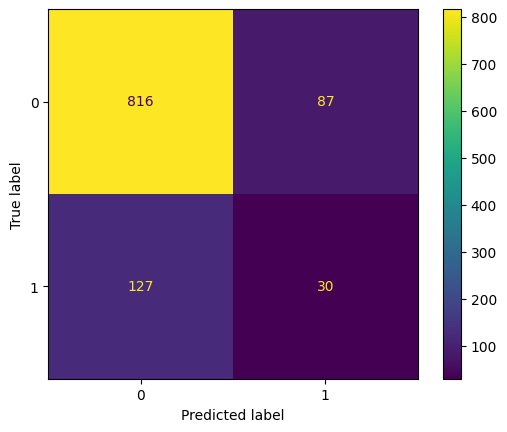

In [8]:
# Model evaluation:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat))
cm.plot()

print(classification_report(y_test, y_hat))

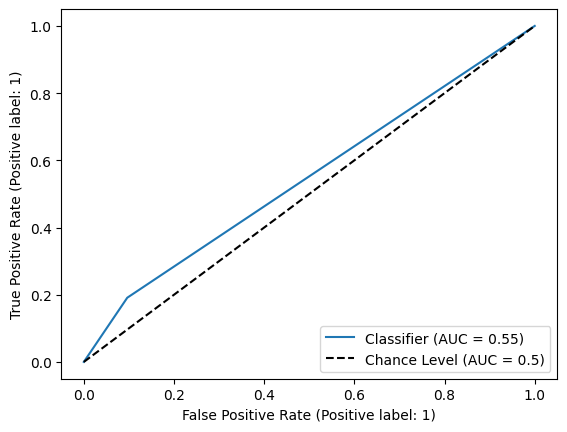

In [9]:
RocCurveDisplay.from_predictions(y_test, y_hat)
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Chance Level (AUC = 0.5)')
plt.legend(loc='lower right')

## Conclusion

> One to two pages summarizing the project, defending it from criticism, and suggesting additional work that was outside the scope of the project.

#### Reference
*All data for this project was derived from the Framingham Heart Study, which is available in our repository and at https://www.framinghamheartstudy.org/*